<a href="https://colab.research.google.com/github/BenShieh233/Learn_Python/blob/main/Randomforest_and_boosted_tree_learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns 

from sklearn.model_selection import train_test_split, cross_val_score
from io import StringIO
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report, roc_curve, auc

##1.Data Preparation

In [4]:
wine = pd.read_csv('/content/sample_data/winequality-red.csv',sep=';')
# Define good_quality as quality > 6
wine["good_quality"] = [0 if i<7 else 1 for i in wine["quality"]]

# Split the training and test sets.
y = wine["good_quality"]
X = wine.drop(["good_quality", "quality"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

##2.Fit a Random Forest

In [8]:
rf = RandomForestRegressor(max_features=11, n_estimators=500, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_features=11, n_estimators=500, random_state=1)

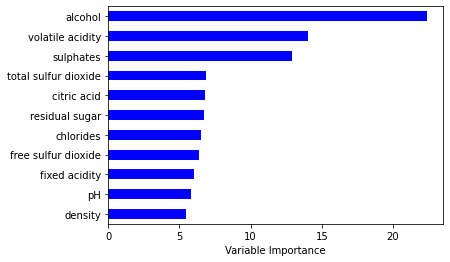

In [9]:
Importance_ = pd.DataFrame({'Importance':rf.feature_importances_*100}, index=X_train.columns)
Importance = Importance_.sort_values('Importance', axis=0, ascending=False)[0:11]
Importance.plot(kind='barh', color='b', ).invert_yaxis()
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [10]:
pred_rf = rf.predict(X_test)

In [13]:
# Confusion Matrix
y_pred = pred_rf > 0.5
table = pd.DataFrame({'Good_quality':y_test,'pred':y_pred})
table.groupby(['Good_quality','pred']).size().unstack('Good_quality')

Good_quality,0,1
pred,,
False,411,21
True,19,29


In [24]:
accuracy = (411+29)/(411+29+19+21)
accuracy

0.9166666666666666

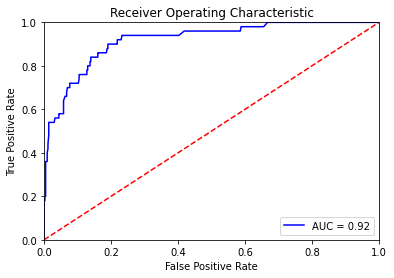

In [11]:
# ROC and AUC
fpr, tpr, threshold = roc_curve(y_test, pred_rf)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [12]:
auc(fpr, tpr)

0.9187674418604651

##3.Fit a Boosted Tree Learner

In [14]:
boost = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.01,random_state=1)
boost.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, n_estimators=5000, random_state=1)

alcohol                 24.678859
volatile acidity        15.504365
sulphates               12.907174
chlorides                7.356645
total sulfur dioxide     6.674216
density                  6.326284
free sulfur dioxide      6.149376
citric acid              5.889859
fixed acidity            5.530245
residual sugar           5.037756
pH                       3.945222
dtype: float64


Text(0.5, 0, 'Variable Importance')

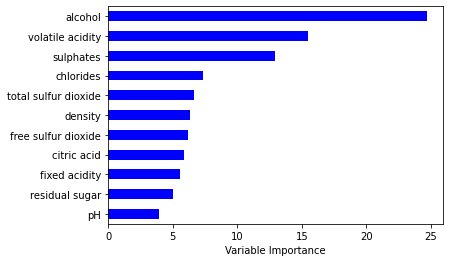

In [15]:
feature_importance = boost.feature_importances_*100
rel_imp = pd.Series(feature_importance, index=X_train.columns).sort_values(ascending=False, inplace=False)
rel_imp = rel_imp[0:11]
print(rel_imp)
rel_imp.plot(kind='barh', color='b', ).invert_yaxis()
plt.xlabel('Variable Importance')

In [16]:
pred_boost = boost.predict(X_test)

In [17]:
# Confusion Matrix
y_pred_boost = pred_boost > 0.5
table = pd.DataFrame({'Good_quality':y_test,'pred':y_pred_boost})
table.groupby(['Good_quality','pred']).size().unstack('Good_quality')

Good_quality,0,1
pred,,
False,403,20
True,27,30


In [22]:
accuracy = (403+30)/(403+30+20+27)
accuracy

0.9020833333333333

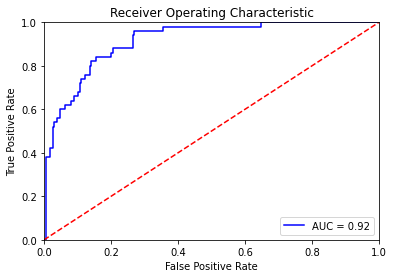

In [23]:
fpr, tpr, threshold = roc_curve(y_test, pred_boost)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#Comparison
wine_tree_prune = DecisionTreeRegressor(ccp_alpha=0.003)
wine_tree_prune.fit(X_train, y_train)
yhat_prune = wine_tree_prune.predict(X_test)
y_pred_prune = yhat_prune > 0.5

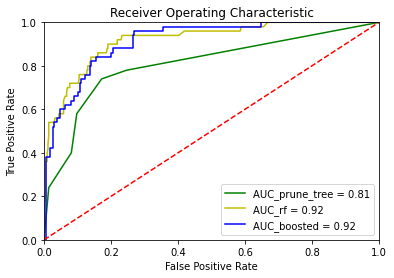

In [32]:
fpr_tree, tpr_tree, threshold_tree = roc_curve(y_test, yhat_prune)
roc_auc_tree = auc(fpr_tree, tpr_tree)
plt.plot(fpr_tree, tpr_tree, 'g', label = 'AUC_prune_tree = %0.2f' % roc_auc_tree)
fpr, tpr, threshold = roc_curve(y_test, pred_rf)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'y', label = 'AUC_rf = %0.2f' % roc_auc)
fpr_boost, tpr_boost, threshold = roc_curve(y_test, pred_boost)
roc_auc_boost = auc(fpr_boost, tpr_boost)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_boost, tpr_boost, 'b', label = 'AUC_boosted = %0.2f' % roc_auc_boost)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [34]:
dict_accuracy = {'accuracy':{'Random_forest':0.9167,'boosted':0.9021, 'CART':0.8646,'Logistics':0.8704,'LDA':0.8661,'QDA':0.8358},'AUC':{'Random_forest':0.9188,'boosted':0.9021,'CART':0.8075,'Logistics':0.8777,'LDA':0.8814,'QDA':0.8458}}
accuracy=pd.DataFrame(dict_accuracy)
accuracy

,accuracy,AUC
Random_forest,0.9167,0.9188
boosted,0.9021,0.9021
CART,0.8646,0.8075
Logistics,0.8704,0.8777
LDA,0.8661,0.8814
QDA,0.8358,0.8458
